# Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from itertools import product

# Configs

In [5]:
INPUT_PATH = 'data/pair_labels.parquet'
OUTPUT_PATH = 'results/pairs_xgb_predictions.parquet'

RIDGE_TEST_PATH = 'ridge/pairs_ridge_test_predictions.parquet'
RIDGE_TRAIN_PATH = 'ridge/pairs_ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [
                'Ridge_predict',
                
                'Previous_week_max_demand',
                'Previous_2week_max_demand',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                'Day_of_month', 
                'Day_of_week',
                ]

VALIDATION_START_DATE = '2023-03-18'
TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Data preparation


## Load Data

In [6]:
labeled_df = pd.read_parquet(INPUT_PATH)

In [7]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (173160, 4)


,PULocation,Date,DOLocation,Demand
0,13,2023-01-01,68,20.0
1,13,2023-01-02,68,19.0
2,13,2023-01-03,68,16.0
3,13,2023-01-04,68,22.0
4,13,2023-01-05,68,31.0


In [8]:
ridge_train_df = pd.read_parquet(RIDGE_TRAIN_PATH)
ridge_test_df = pd.read_parquet(RIDGE_TEST_PATH)
ridge_df = pd.concat([ridge_train_df, ridge_test_df], axis = 0)

In [9]:
print(f'ridge dataframe shape : {ridge_df.shape}')
ridge_df.head()

ridge dataframe shape : (152958, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-01-15,68,21.475281
1,13,2023-01-16,68,22.627233
2,13,2023-01-17,68,24.706275
3,13,2023-01-18,68,28.056815
4,13,2023-01-19,68,23.941366


## Add Feature

In [10]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(14)

    dataset['Previous_week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=7).max().reset_index(drop = True)
    dataset['Previous_2week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=14).max().reset_index(drop = True)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek + 1
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    dataset = (
        dataset
        .merge(ridge_df, how='left', on=['PULocation', 'Date', 'DOLocation'])
        .rename(columns = {'Predicted_demand' : 'Ridge_predict'})
        )
    
    return dataset


In [11]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [12]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (152958, 23)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month,Ridge_predict
14,13,2023-01-15,68,17.0,32.0,31.0,24.0,42.0,30.0,22.0,...,31.0,22.0,16.0,19.0,20.0,42.0,42.0,7,15,21.475281
15,13,2023-01-16,68,13.0,17.0,32.0,31.0,24.0,42.0,30.0,...,18.0,31.0,22.0,16.0,19.0,42.0,42.0,1,16,22.627233
16,13,2023-01-17,68,23.0,13.0,17.0,32.0,31.0,24.0,42.0,...,15.0,18.0,31.0,22.0,16.0,42.0,42.0,2,17,24.706275
17,13,2023-01-18,68,25.0,23.0,13.0,17.0,32.0,31.0,24.0,...,10.0,15.0,18.0,31.0,22.0,32.0,42.0,3,18,28.056815
18,13,2023-01-19,68,22.0,25.0,23.0,13.0,17.0,32.0,31.0,...,22.0,10.0,15.0,18.0,31.0,32.0,42.0,4,19,23.941366


In [13]:
features_df[features_df['Demand'] == 0]

,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month,Ridge_predict


## Split Train and Test Data

In [14]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [15]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [16]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_START_DATE) 

In [17]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (109668, 23)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month,Ridge_predict
14,13,2023-01-15,68,17.0,32.0,31.0,24.0,42.0,30.0,22.0,...,31.0,22.0,16.0,19.0,20.0,42.0,42.0,7,15,21.475281
15,13,2023-01-16,68,13.0,17.0,32.0,31.0,24.0,42.0,30.0,...,18.0,31.0,22.0,16.0,19.0,42.0,42.0,1,16,22.627233
16,13,2023-01-17,68,23.0,13.0,17.0,32.0,31.0,24.0,42.0,...,15.0,18.0,31.0,22.0,16.0,42.0,42.0,2,17,24.706275
17,13,2023-01-18,68,25.0,23.0,13.0,17.0,32.0,31.0,24.0,...,10.0,15.0,18.0,31.0,22.0,32.0,42.0,3,18,28.056815
18,13,2023-01-19,68,22.0,25.0,23.0,13.0,17.0,32.0,31.0,...,22.0,10.0,15.0,18.0,31.0,32.0,42.0,4,19,23.941366


In [18]:
print(f'validation dataframe shape : {valid_df.shape}')
valid_df.head()

validation dataframe shape : (20202, 23)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month,Ridge_predict
76,13,2023-03-18,68,18.0,25.0,28.0,29.0,24.0,14.0,15.0,...,35.0,19.0,16.0,12.0,19.0,29.0,36.0,6,18,16.237615
77,13,2023-03-19,68,14.0,18.0,25.0,28.0,29.0,24.0,14.0,...,36.0,35.0,19.0,16.0,12.0,29.0,36.0,7,19,13.258240
78,13,2023-03-20,68,20.0,14.0,18.0,25.0,28.0,29.0,24.0,...,20.0,36.0,35.0,19.0,16.0,29.0,36.0,1,20,15.023794
79,13,2023-03-21,68,36.0,20.0,14.0,18.0,25.0,28.0,29.0,...,15.0,20.0,36.0,35.0,19.0,36.0,36.0,2,21,24.283424
80,13,2023-03-22,68,30.0,36.0,20.0,14.0,18.0,25.0,28.0,...,15.0,15.0,20.0,36.0,35.0,36.0,36.0,3,22,35.046049


In [19]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (43290, 23)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month,Ridge_predict
90,13,2023-04-01,68,18.0,35.0,28.0,37.0,32.0,21.0,21.0,...,30.0,36.0,20.0,14.0,18.0,37.0,37.0,6,1,22.153462
91,13,2023-04-02,68,16.0,18.0,35.0,28.0,37.0,32.0,21.0,...,32.0,30.0,36.0,20.0,14.0,37.0,37.0,7,2,18.887359
92,13,2023-04-03,68,24.0,16.0,18.0,35.0,28.0,37.0,32.0,...,22.0,32.0,30.0,36.0,20.0,37.0,37.0,1,3,23.965120
93,13,2023-04-04,68,31.0,24.0,16.0,18.0,35.0,28.0,37.0,...,15.0,22.0,32.0,30.0,36.0,37.0,37.0,2,4,33.974492
94,13,2023-04-05,68,32.0,31.0,24.0,16.0,18.0,35.0,28.0,...,21.0,15.0,22.0,32.0,30.0,35.0,37.0,3,5,33.842866


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [20]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        current_model.fit(train_df[feature_list], train_df['Demand'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['Demand'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [21]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.05, 0.1], 
                'subsample':[0.8, 0.9], 
                'colsample_bytree':[0.7, 0.8, 0.9], 
                'max_depth':[7, 8, 9, 10], 
                'min_child_weight':[10, 20],
                'n_estimators':[80, 90, 100]
                }

    best_params, best_score = grid_search(
        model_class = xgb.XGBRegressor, 
        param_grid = params_test,
        train_df = grid_search_train_df, 
        val_df = valid_df,
        feature_list = FEATURE_LIST, 
        )
    
    print(best_params, best_score)
else:
    best_params = { 
        'learning_rate': 0.05, 
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'max_depth': 10, 
        'min_child_weight': 20, 
        'n_estimators': 80
        }

### Prediction

In [22]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [23]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [24]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
    test_data['Day_of_year'] = test_data['Date'].dt.dayofyear

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('Day_of_year')['Demand'].sum()
    test_data = test_data.groupby('Day_of_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('Day_of_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('Day_of_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\NPC\AppData\Local\Temp\ipykernel_13720\242743045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_13720\242743045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Day_of_year'] = test_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_13720\242743045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

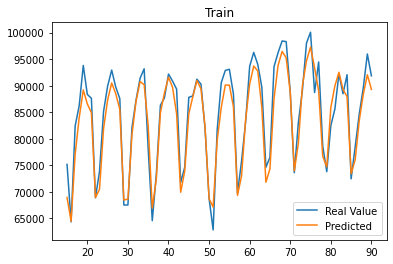

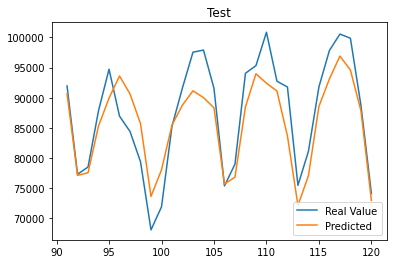

In [25]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [26]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [27]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)

In [28]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 7.028209352643727
MSE : 104.36012474920803
MAPE : 0.16230070960037013

XGB test scores:
MAE : 8.313337142551763
MSE : 174.29775555293662
MAPE : 0.17679231997819403


### Feature Importance and SHAPE

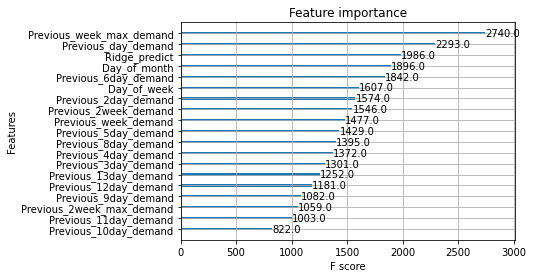

In [29]:
xgb.plot_importance(model)
plt.show()

In [25]:
'''dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])'''

"dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)\n\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(dtrain_reg)\nshap.summary_plot(shap_values, train_df[FEATURE_LIST])"

# File Saving

In [30]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [31]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['PULocation', 'Date', 'DOLocation']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [32]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

C:\Users\NPC\AppData\Local\Temp\ipykernel_13720\3058505207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [33]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,21.043465
1,13,2023-04-02,68,17.703024
2,13,2023-04-03,68,24.283808
3,13,2023-04-04,68,29.548220
4,13,2023-04-05,68,30.430885


In [34]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)